# Master Project - 1. Milestone

### Exploration of Bandit Algorithms

Author: Marvin Ernst

Date: February 11, 2025

##### Explaining the setup:

Usually what we would like to find is for the simple case, just which algorithm performs the best. In this setting we do not actually have algorithms (i.e. the arms), however, the arms still reperesnt choices one can make, where each of these arms is associated with a probability of success. It is a bandit problem (or specifically a multi-armed bandit problem), because we (the player) do not know a priori what these probabilities are. The goal is to learn which arm has the highest expected reward by experimenting with them. 

In our base implementation:

-	We have 5 arms (representing 5 different algorithms or choices).

-	Each arm has a true but hidden probability of giving a reward (this is its “quality”).

-	When an arm is pulled (chosen), the outcome is determined probabilistically.

-   We compare two policies, choosing an arm by random and by Thompson Sampling.

- We include the Upper Confidence Bound (UCB) Algortihm.

-  In the latest update I also added the tuned UCB Algortihm.


Importing relevant Libraries:

In [26]:
import numpy as np
import matplotlib.pyplot as plt

Set random seed for reproducibility:

In [27]:
np.random.seed(42)

### 1. A Multi-Armed Bandit environment


Initialize a multi-armed bandit problem with K arms.
Each arm has a fixed (but unknown) reward probability.


Simulate pulling an arm, returning a reward (1 with probability true_means[arm], otherwise 0).

In [28]:
class MultiArmedBandit:
    def __init__(self, k=5):
        self.k = k  # Number of arms
        self.true_means = np.random.rand(k)  # True (unknown) reward probabilities
    
    def pull_arm(self, arm):
        return 1 if np.random.rand() < self.true_means[arm] else 0

### 2. Random policy for baseline comparison

Randomly select an arm.

In [29]:
class RandomPolicy:
    def __init__(self, k):
        self.k = k
    
    def select_arm(self):
        return np.random.choice(self.k)

### 3. Thompson Sampling implementation

##### Definition:

Thompson Sampling (TS) is a Bayesian approach to the bandit problem. Instead of using simple statistical estimates, TS maintains a probabilistic belief over the reward of each arm and updates this belief over time.

**How it works:**

1. Initialize priors: 

    Each arm starts with a Beta distribution (Beta(1,1)), which represents our initial belief about the reward of each arm.

2.	Sampling step: At each round:

	-	We sample from the Beta distribution for each arm.

	-	We select the arm with the highest sampled value.

3.	Update step:

	-	If the selected arm gets a reward, we increase the success count.

	-	If it does not, we increase the failure count.

	-	This updates our belief about that arm’s effectiveness.


*Beta Distribution in Thompson Sampling:*

$\text{Beta}(\alpha_k, \beta_k)$

- $\alpha_k$ = number of successes for arm $k$  
- $\beta_k$ = number of failures for arm $k$  


In [30]:
class ThompsonSampling:
    def __init__(self, k):
        self.k = k
        self.alpha = np.ones(k)  # Success counts
        self.beta = np.ones(k)   # Failure counts
    
    def select_arm(self):
        samples = [np.random.beta(self.alpha[i], self.beta[i]) for i in range(self.k)]
        return np.argmax(samples)
    
    def update(self, arm, reward): # herre we update the distribution based on observed reward
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward

### 4. Upper Confidence Bounds (UCB)

We implement the upper confidence bound algorithm. 

Select an arm based on the UCB strategy.

Then, we update estimates based on observed reward.

In [31]:
class UCB:
    def __init__(self, k):
        self.k = k
        self.counts = np.zeros(k)  # Number of times each arm was selected
        self.values = np.zeros(k)  # Estimated value of each arm
    
    def select_arm(self, t):
        if 0 in self.counts:
            return np.argmin(self.counts)  # Play each arm at least once
        
        ucb_values = self.values + np.sqrt((2 * np.log(t)) / self.counts)
        return np.argmax(ucb_values)
    
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

### 4. Upper Confidence Bounds Tuned (UCB-Tuned)

We implement the tuned upper confidence bound algorithm.

Unlike standard UCB1, which uses a fixed exploration term based on the number of arm pulls, UCB-Tuned incorporates the empirical variance of each arm to adaptively balance exploration and exploitation. This helps when reward distributions differ in variability (e.g., for Bernoulli rewards with different success probabilities).

The arm selection rule at round t is:

$$\text{Select } \arg\max_k \left[ \hat{\mu}_k(t) + \sqrt{ \frac{\log t}{N_k(t)} \cdot \min\left( \frac{1}{4}, V_k(t) + \sqrt{ \frac{2 \log t}{N_k(t)} } \right) } \right]$$

where:

- $\hat{\mu}_k(t)$ is the empirical mean reward of arm k up to time t,

- $N_k(t)$ is the number of times arm k has been selected up to time t,

- $V_k(t)$ is the empirical variance of the rewards from arm k,

- The term $\frac{1}{4}$ is the maximum variance for a Bernoulli reward.

This formulation adjusts the exploration bonus based on the variability observed so far, and typically leads to lower regret when variances across arms differ significantly.



In [32]:
class UCBTuned:
    def __init__(self, k):
        self.k = k
        self.counts = np.zeros(k)
        self.values = np.zeros(k)
        self.rewards = [[] for _ in range(k)]
    
    def select_arm(self, t):
        for i in range(self.k):
            if self.counts[i] == 0:
                return i  # Play each arm once
        
        ucb_values = []
        for i in range(self.k):
            avg = self.values[i]
            variance = np.var(self.rewards[i]) if self.counts[i] > 1 else 0.25  # max variance for Bernoulli
            bonus = np.sqrt((np.log(t) / self.counts[i]) * min(0.25, variance + np.sqrt(2 * np.log(t) / self.counts[i])))
            ucb_values.append(avg + bonus)
        
        return np.argmax(ucb_values)
    
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.rewards[arm].append(reward)
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

### 6. Simulation with regret tracking and visualization

In [33]:
n_runs = 100
n_rounds = 1000
k = 5

# For storing results
random_regrets_all = np.zeros((n_runs, n_rounds))
thompson_regrets_all = np.zeros((n_runs, n_rounds))
ucb1_regrets_all = np.zeros((n_runs, n_rounds))
ucb2_regrets_all = np.zeros((n_runs, n_rounds))

thompson_selections_all = np.zeros((n_runs, k))
ucb1_selections_all = np.zeros((n_runs, k))
ucb2_selections_all = np.zeros((n_runs, k))

# Count which arm was truly best across all runs
true_best_counts = np.zeros(k)

for run in range(n_runs):
    bandit = MultiArmedBandit(k)
    best_arm = np.argmax(bandit.true_means)
    true_best_counts[best_arm] += 1

    random_policy = RandomPolicy(k)
    thompson_policy = ThompsonSampling(k)
    ucb_policy1 = UCB(k)
    ucb_policy2 = UCBTuned(k)

    optimal_reward = max(bandit.true_means)

    random_regret = []
    thompson_regret = []
    ucb1_regret = []
    ucb2_regret = []

    thompson_sel = np.zeros(k)
    ucb1_sel = np.zeros(k)
    ucb2_sel = np.zeros(k)

    for t in range(1, n_rounds + 1):
        # Random
        rand_arm = random_policy.select_arm()
        rand_reward = bandit.pull_arm(rand_arm)
        random_regret.append(optimal_reward - bandit.true_means[rand_arm])

        # Thompson
        thompson_arm = thompson_policy.select_arm()
        thompson_reward = bandit.pull_arm(thompson_arm)
        thompson_policy.update(thompson_arm, thompson_reward)
        thompson_regret.append(optimal_reward - bandit.true_means[thompson_arm])
        thompson_sel[thompson_arm] += 1

        # UCB1
        ucb1_arm = ucb_policy1.select_arm(t)
        ucb1_reward = bandit.pull_arm(ucb1_arm)
        ucb_policy1.update(ucb1_arm, ucb1_reward)
        ucb1_regret.append(optimal_reward - bandit.true_means[ucb1_arm])
        ucb1_sel[ucb1_arm] += 1

        # UCB-Tuned
        ucb2_arm = ucb_policy2.select_arm(t)
        ucb2_reward = bandit.pull_arm(ucb2_arm)
        ucb_policy2.update(ucb2_arm, ucb2_reward)
        ucb2_regret.append(optimal_reward - bandit.true_means[ucb2_arm])
        ucb2_sel[ucb2_arm] += 1

    # Store regrets and selections
    random_regrets_all[run] = np.cumsum(random_regret)
    thompson_regrets_all[run] = np.cumsum(thompson_regret)
    ucb1_regrets_all[run] = np.cumsum(ucb1_regret)
    ucb2_regrets_all[run] = np.cumsum(ucb2_regret)

    thompson_selections_all[run] = thompson_sel
    ucb1_selections_all[run] = ucb1_sel
    ucb2_selections_all[run] = ucb2_sel

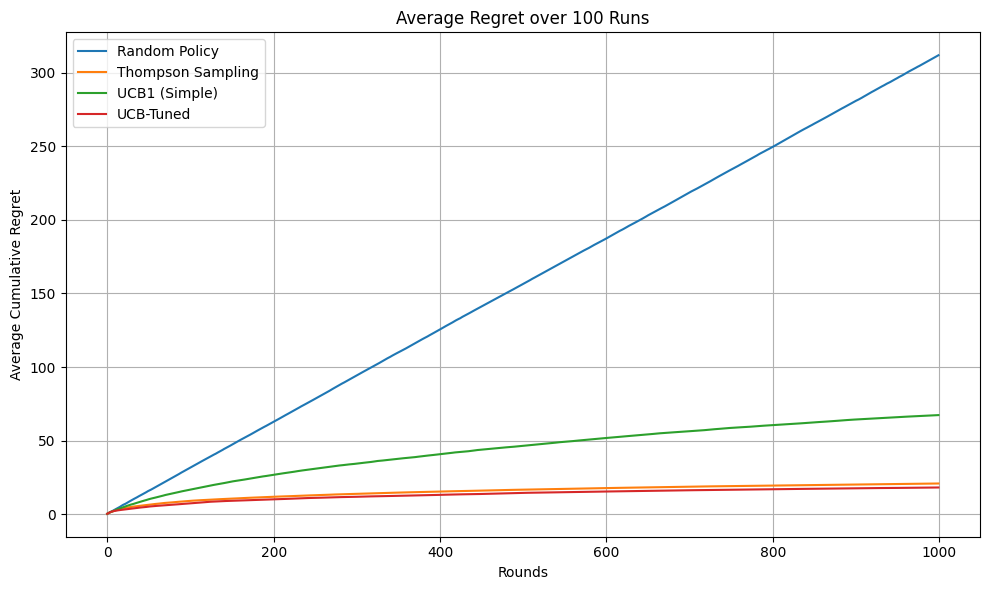

In [34]:
plt.figure(figsize=(10, 6))

plt.plot(np.mean(random_regrets_all, axis=0), label='Random Policy')
plt.plot(np.mean(thompson_regrets_all, axis=0), label='Thompson Sampling')
plt.plot(np.mean(ucb1_regrets_all, axis=0), label='UCB1 (Simple)')
plt.plot(np.mean(ucb2_regrets_all, axis=0), label='UCB-Tuned')

plt.xlabel("Rounds")
plt.ylabel("Average Cumulative Regret")
plt.title("Average Regret over {} Runs".format(n_runs))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Random Policy: Worst performance (no learning).
 
- UCB1: Learns, but explores too much, leading to unnecessary regret.
 
- UCB-Tuned: A strong competitor to Thompson Sampling, and a significant improvement over standard UCB1.

- Thompson Sampling: Best performer here - fastest learning, lowest regret.

#### Expected (mean) Selections Across Runs

In [35]:
avg_thompson_sel = np.mean(thompson_selections_all, axis=0)
avg_ucb1_sel = np.mean(ucb1_selections_all, axis=0)
avg_ucb2_sel = np.mean(ucb2_selections_all, axis=0)
expected_best_sel = true_best_counts * n_rounds / n_runs

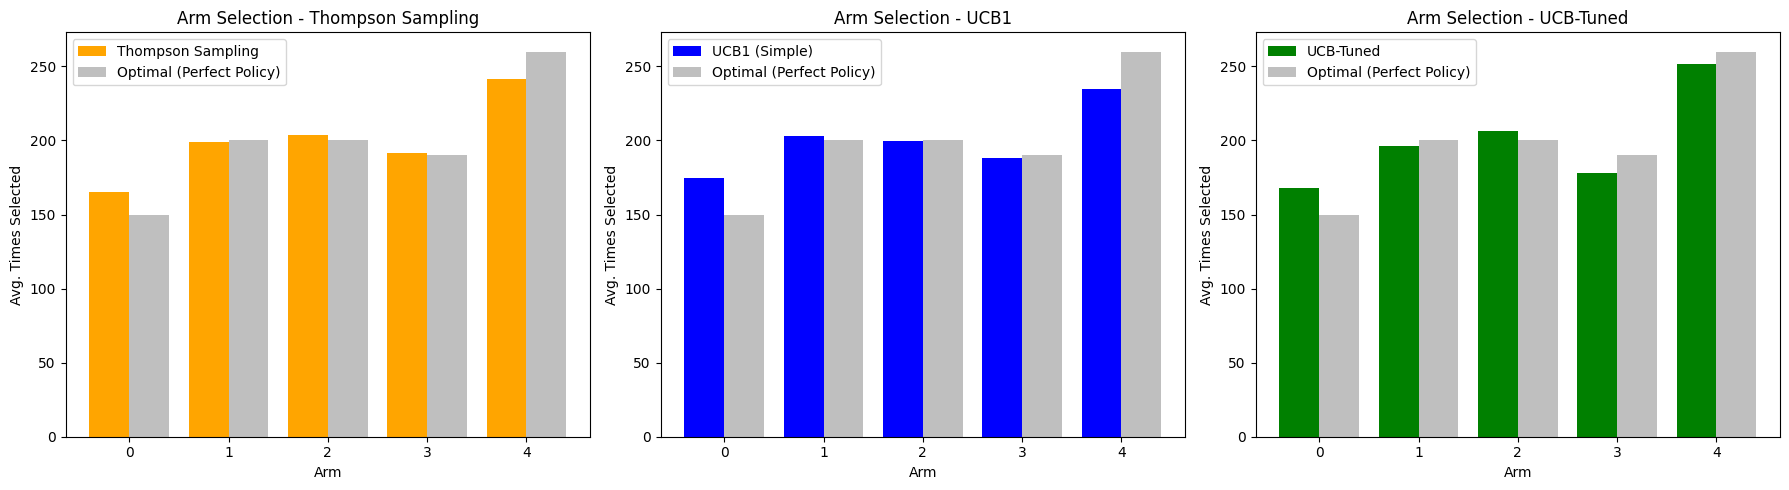

In [36]:
bar_width = 0.4
x = np.arange(k)

plt.figure(figsize=(18, 5))

# Thompson Sampling
plt.subplot(1, 3, 1)
plt.bar(x - bar_width/2, avg_thompson_sel, width=bar_width, color='orange', label='Thompson Sampling')
plt.bar(x + bar_width/2, expected_best_sel, width=bar_width, color='gray', alpha=0.5, label='Optimal (Perfect Policy)')
plt.xlabel('Arm')
plt.ylabel('Avg. Times Selected')
plt.title('Arm Selection - Thompson Sampling')
plt.legend()

# UCB1 (Simple)
plt.subplot(1, 3, 2)
plt.bar(x - bar_width/2, avg_ucb1_sel, width=bar_width, color='blue', label='UCB1 (Simple)')
plt.bar(x + bar_width/2, expected_best_sel, width=bar_width, color='gray', alpha=0.5, label='Optimal (Perfect Policy)')
plt.xlabel('Arm')
plt.ylabel('Avg. Times Selected')
plt.title('Arm Selection - UCB1')
plt.legend()

# UCB-Tuned
plt.subplot(1, 3, 3)
plt.bar(x - bar_width/2, avg_ucb2_sel, width=bar_width, color='green', label='UCB-Tuned')
plt.bar(x + bar_width/2, expected_best_sel, width=bar_width, color='gray', alpha=0.5, label='Optimal (Perfect Policy)')
plt.xlabel('Arm')
plt.ylabel('Avg. Times Selected')
plt.title('Arm Selection - UCB-Tuned')
plt.legend()

plt.tight_layout()
plt.show()

The plots show that all three policies—Thompson Sampling, UCB1, and UCB-Tuned—learn to favor Arm 4, which was the optimal arm most often across the runs. Thompson Sampling and UCB-Tuned come closest to matching the selection pattern of a perfect policy, especially for the best arm. UCB1 explores a bit more evenly and under-selects Arm 4 slightly, reflecting its more aggressive exploration strategy. Overall, the alignment between the policy bars and the gray optimal bars confirms that all policies are learning well, with Thompson Sampling and UCB-Tuned being the most efficient.